## Overview

In this tutorial, we will build a simple aritificial neural network (ANN), also known as multilayer perceptron (MLP) or feedforward neural network (FNN). The learning outcomes are:
1. Understand how the model is formulated mathematically;
2. Understand what is meant by training the network;
3. Experiment with more complex architectures.

## Data

We generate data from a Gaussian process with a specified covariance matrix. The details of data generation do not matter as in reality, you never know the actual data generation machanism.

**The key** here is that we want to predict $y \in R^5$ given the previous values $x\in R^{25}$.

In [1]:
# first let's generate data, you can ignore this part
import numpy as np
import sys
import os
sys.path.insert(1, '..')
os.chdir('..')

from data_formatters.iglu import *
from dataset import TSDataset
from conf import Conf

import torch
from torch.utils.data import TensorDataset

# load config file
cnf = Conf(conf_file_path='./conf/iglu.yaml', seed=15, exp_name="IGLU", log=False)
data_formatter = IGLUFormatter(cnf)

# set up torch datasets: train, val, test
train_dataset = TSDataset(cnf, data_formatter, data_formatter.train_data)
val_dataset = TSDataset(cnf, data_formatter, data_formatter.val_data)
test_dataset = TSDataset(cnf, data_formatter, data_formatter.test_data)

# train_idx, test_idx, val_idx = map(set, data_formatter.split_data())
# train, test, val = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

# for index, row in data_formatter.data.iterrows():
#     if index in train_idx:
#         train.append(row)
#     elif index in test_idx:
#         test.append(row)
#     else:
#         val.append(row)

# # These are empty for some reason
# print(train, test, val)
# x_columns = ["time"]
# y_columns = ["gl"]
# train_x, test_x, val_x, = map(lambda x: x[x_columns], [train, test, val])
# train_y, test_y, val_y, = map(lambda x: x[y_columns], [train, test, val])

# train_dataset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
# test_dataset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
# val_dataset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
# # set up torch dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Dropped segments: 11
Extracted segments: 21
Getting valid sampling locations.
# available segments=5710
Extracting 5000 samples out of 5710
1000 of 5000 samples done...
2000 of 5000 samples done...
3000 of 5000 samples done...
4000 of 5000 samples done...
5000 of 5000 samples done...
Getting valid sampling locations.
# available segments=11
Extracting all available segments.
Getting valid sampling locations.
# available segments=776
Extracting all available segments.


## Linear regression

Suppose we want to model our data as a linear transformation, that is we aim to find $W \in R^{25\times 5}$ so that to minimize the squared error between the prediction and the truth. In summary, we formulate the problem as:
$$
W^* = \argmin_{W} || Y -  XW ||^2
$$

This model is an extension of the model many of us have covered in the introductory statisics courses to a multivariate case. **Recall** that for one-dimensional case (i.e. when $y \in R$) and under some distributional assumptions, this optimization problem has a closed form solution that is guaranteed to be the best (BLUE). When we move to more dimensions and start relaxing the assumptions, we no longer have the closed-form solution. Hence, we need to resort to the apprximate methods. Below, we program the model and see its performance.

In [2]:
import torch
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear_collapse = torch.nn.Linear(6, 1)
        self.linear = torch.nn.Linear(192, 24)
        
    def forward(self, x):
        y_pred = self.linear(torch.squeeze(self.linear_collapse(x)))
        return y_pred

In [3]:
# train model
best_loss = 1e1000
model = LinearModel()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(100):
    # for i, (inputs, labels) in enumerate(train_loader):
    for i, d in enumerate(train_loader):
        # Forward pass
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        # for i, (inputs, labels) in enumerate(val_loader):
        for i, d in enumerate(val_loader):
            outputs = model(d.get('inputs'))
            loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model_linear.pth')
# load best model
model.load_state_dict(torch.load('best_model_linear.pth'))

Epoch [1/100], Loss: 0.6057
Epoch [1/100], Val Loss: 1.5867
Epoch [2/100], Loss: 0.1919
Epoch [2/100], Val Loss: 0.9643
Epoch [3/100], Loss: 0.2605
Epoch [3/100], Val Loss: 0.7375
Epoch [4/100], Loss: 0.3327
Epoch [4/100], Val Loss: 0.6369
Epoch [5/100], Loss: 0.1515
Epoch [5/100], Val Loss: 0.5410
Epoch [6/100], Loss: 0.1730
Epoch [6/100], Val Loss: 0.4866
Epoch [7/100], Loss: 0.1934
Epoch [7/100], Val Loss: 0.4364
Epoch [8/100], Loss: 0.2107
Epoch [8/100], Val Loss: 0.4020
Epoch [9/100], Loss: 0.2978
Epoch [9/100], Val Loss: 0.3678
Epoch [10/100], Loss: 0.1956
Epoch [10/100], Val Loss: 0.3473
Epoch [11/100], Loss: 0.3319
Epoch [11/100], Val Loss: 0.3288
Epoch [12/100], Loss: 0.6714
Epoch [12/100], Val Loss: 0.3205
Epoch [13/100], Loss: 0.2065
Epoch [13/100], Val Loss: 0.3089
Epoch [14/100], Loss: 0.3307
Epoch [14/100], Val Loss: 0.3047
Epoch [15/100], Loss: 0.2381
Epoch [15/100], Val Loss: 0.2941
Epoch [16/100], Loss: 0.1234
Epoch [16/100], Val Loss: 0.2922
Epoch [17/100], Loss: 0.43

<All keys matched successfully>

In [4]:
# evaluate model on test set
with torch.no_grad():
    for i, d in enumerate(test_loader):
        outputs = model(d['inputs'])
        labels = torch.squeeze(d['outputs'])
        loss = criterion(outputs, labels)
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [100/100], Test Loss: 0.1505


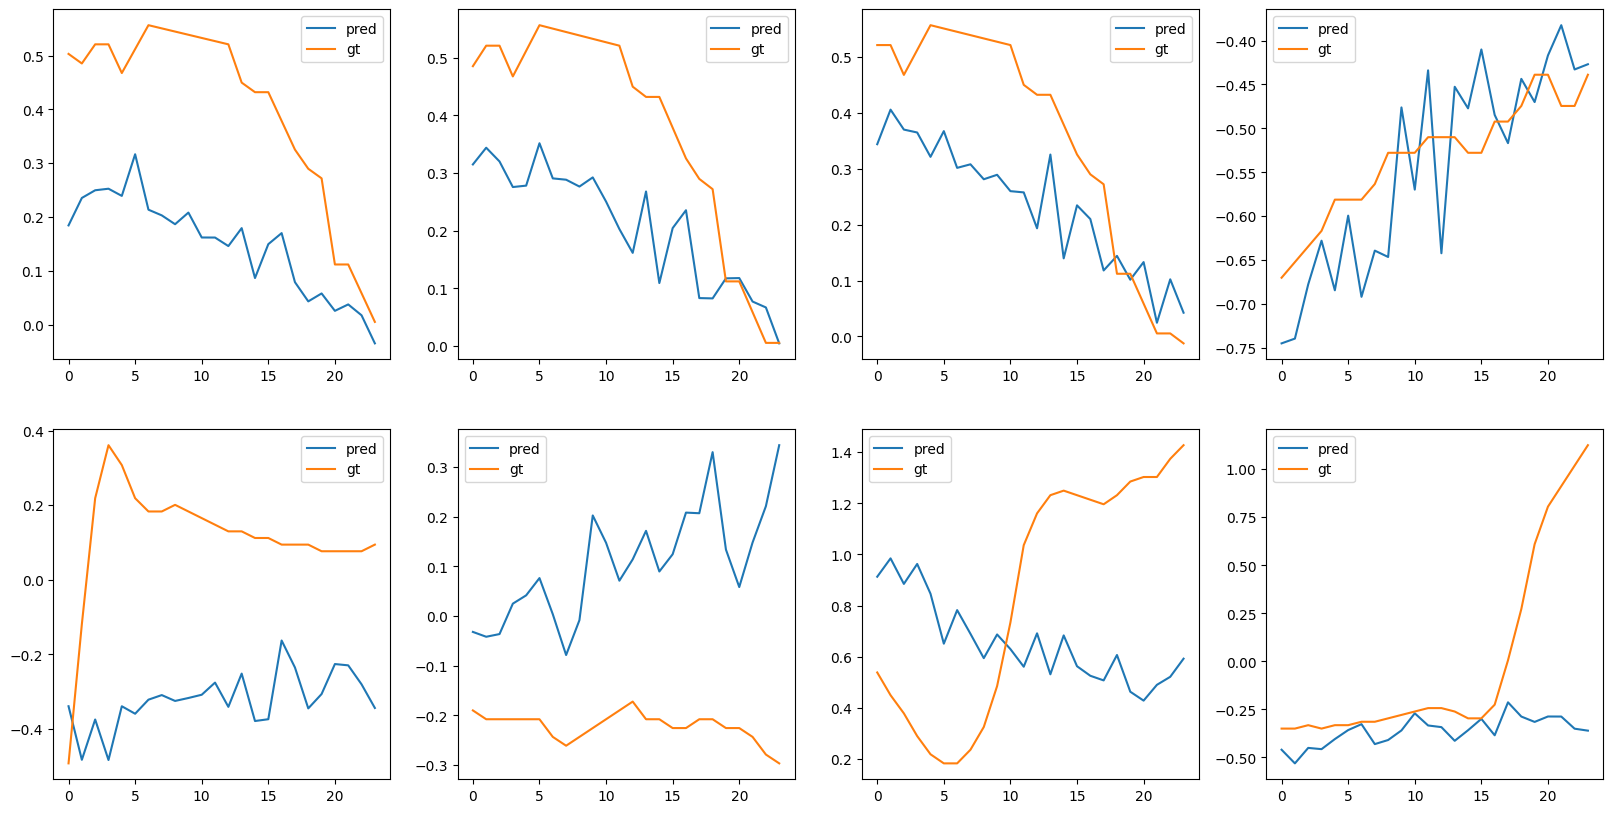

In [5]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()

## Can we do better?

In our case, there is little justification to move beyond the linear regression setting because of how the data is generated. Nevertheless, nobody is stopping us from trying. Let's now formulate our model as: $$\hat y  = (ReLU(XW^{(1)})) W^{(2)},$$
where $W^{(1)} \in R^{25 \times n_1}, W^{(2)} \in R^{n_1 \times 5}$ are learnable weight matrie and $n_1$ is a hyper-parameter we get to choose.

The main points we want to you to notice from this example are:
1. More complex models do not mean better performance;
2. Hyper-parameter tuning is tedious;
3. **Most importantly**, we can learn any differentiable architecture with the help of SGD.

In [6]:
# define model
import torch
class MLP(torch.nn.Module):
    def __init__(self, n1):
        super(MLP, self).__init__()
        self.linear = torch.nn.Linear(25, n1)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(n1, 5)
        
    def forward(self, x):
        y_pred = self.linear2(self.relu(self.linear(x)))
        return y_pred

In [7]:
# train model
best_loss = 1e10
model = MLP(100)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(100):
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model.pth')
# load best model
model.load_state_dict(torch.load('best_model.pth'))

ValueError: too many values to unpack (expected 2)

In [ ]:
# evaluate model on test set
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

In [ ]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()